# Preamble

In [1]:
%matplotlib widget

import os, glob, pathlib
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from mpl_styles import analytic
from scipy.special import hyp2f1
from sympy import init_printing, init_session

from loky import get_reusable_executor
import dill as pickle

plt.style.use(analytic)
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return 0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return 0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))

def fs1(alpha):
    """
    fs,1 in MD table 8.4 p. 331
    (1/8)*(2*α*D+α**2*D^2)*b^(0)_(1/2)(α)
    """
    return 0.125 * (2*alpha*Db(0.5,0,alpha) + alpha**2*D2b(0.5,0,alpha))

def fs2(alpha):
    """ 
    fs,2 in MD table 8.4 p. 331
    (1/4)*(2-2*α*D-α**2*D^2)*b^(1)_(1/2)(α)
    """
    return 0.25*(2*b(0.5,1,alpha)-2*alpha*Db(0.5,1,alpha)-alpha**2*D2b(0.5,1,alpha))

alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

############################################################
# If test particle is outside, have to multiply by alpha_0 #
############################################################

f1val = f27lc(alpha0, 2)
f2val = f31lc(alpha0, 2)
f3val = fs1(alpha0)
f4val = fs2(alpha0)

IPython console for SymPy 1.11.1 (Python 3.11.3-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



In [2]:
f1val, f2val, f3val, f4val

# Poisson Bracket

In [3]:
class PoissonBracket:
    def __init__(self, q, p):
        """
        q : list of canonical coordinates
        p : list of canonical momenta
        """
        self.dim = len(q)
        if len(p) != self.dim:
            raise Warning("Mismatch in canonical conjugate pair dimensions.")
        self.q = q
        self.p = p
    def __call__(self, f, g):
        """
        f, g : Functions of canonical conjugate pairs p, q
        """
        bracket = 0
        for i in range(self.dim):
            bracket += f.diff(self.p[i])*g.diff(self.q[i]) - g.diff(self.p[i])*f.diff(self.q[i])
        return(bracket)

# Hamiltonian and Canonical Variables

In [4]:
a1, a2, e1, e2, mu2, l1, l2, pom1, pom2, f1, f2, f3, f4, j, om1, om2 = symbols(
    r"a_1 a_2 e_1 e_2 mu_2 lambda_1 lambda_2 varpi_1 varpi_2 f_1 f_2 f_3 f_4 j \omega_{1\rm{e}} \omega_{2\rm{e}}"
)
q = symbols(r"q", positive=True)
calH = (
    -q / (2 * a1)
    - 1 / (2 * a2)
    - q* mu2/ a2
    * f1 * e1 * cos((j + 1) * l2 - j * l1 - pom1)
    - q* mu2/ a2* f2 * e2 * cos((j + 1) * l2 - j * l1 - pom2)
    -om1*Rational(1,2)*q*sqrt(a1)*e1**2
    -om2*Rational(1,2)*sqrt(a2)*e2**2
    -q*mu2/a2*f3*(e1**2+e2**2) -q*mu2/a2*f4*e1*e2*cos(pom1-pom2)
)
calH

In [5]:
L1, L2, G1, G2 = symbols("Lambda_1 Lambda_2 Gamma_1 Gamma_2", positive=True)
g1, g2 = symbols("gamma_1 gamma_2")

In [6]:
def orbelts_to_delaunay(expr):
    return expr.subs(
        {
            e1: sqrt(2 * G1 / L1),
            e2: sqrt(2 * G2 / L2),
            a1: L1**2/q**2,
            a2: L2**2,
            pom1: -g1,
            pom2: -g2,
        }
    )


def delaunay_to_orbelts(expr):
    return expr.subs(
        {
            g1: -pom1,
            g2: -pom2,
            G1: Rational(1, 2) * L1 * e1**2,
            G2: Rational(1, 2) * L2 * e2**2,
            L1: q*sqrt(a1),
            L2: sqrt(a2),
        }
    )

# Canonical transformations for numerical experiments

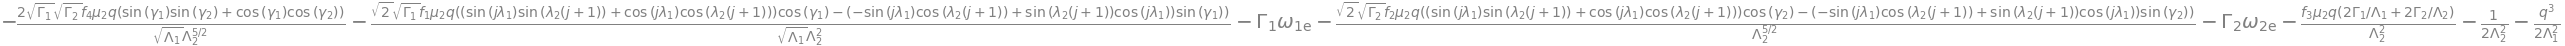

In [7]:
H1 = expand_trig(orbelts_to_delaunay(calH).subs({sqrt(L1**2):L1,sqrt(L2**2):L2}))
H1

In [8]:
X1, X2, Y1, Y2 = symbols("X_1 X_2 Y_1 Y_2")
PBgG = PoissonBracket([g1, g2], [G1, G2])
X1_expr, Y1_expr = sqrt(2*G1) * sin(g1), sqrt(2*G1) * cos(g1)
X2_expr, Y2_expr = sqrt(2*G2) * sin(g2), sqrt(2*G2) * cos(g2)
display(PBgG(Y1_expr,X1_expr).simplify())
display(PBgG(Y2_expr,X2_expr).simplify())

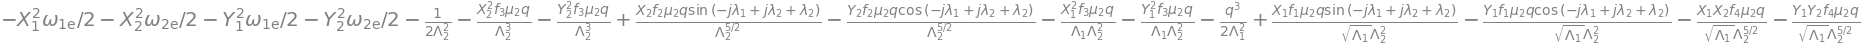

In [9]:
H2 = H1.subs(
    {
        sin(g1): X1 / sqrt(2 * G1),
        cos(g1): Y1 / sqrt(2 * G1),
        sin(g2): X2 / sqrt(2 * G2),
        cos(g2): Y2 / sqrt(2 * G2),
        G1:Rational(1,2)*(X1**2+Y1**2),
        G2:Rational(1,2)*(X2**2+Y2**2),
    }
).trigsimp()#.simplify(deep=True).expand()
H2

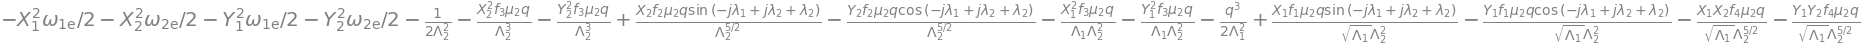

In [10]:
H3 = 0
for term in H2.args:
    H3 += term.cancel().simplify(deep=True).factor()
H3

# Dissipation

In [11]:
Te1, Te2, Tm1, Tm2 = symbols(r"T_{\rm{e}1} T_{\rm{e}2} T_{\rm{m}1} T_{\rm{m}2}")

In [12]:
a1dot_dis = -a1/Tm1 - 2*e1**2*a1/Te1
a2dot_dis = -a2/Tm2 - 2*e2**2*a2/Te2

e1dot_dis = -e1/Te1
e2dot_dis = -e2/Te2

a1dot_dis,e1dot_dis,a2dot_dis,e2dot_dis

In [13]:
L1dot_dis = orbelts_to_delaunay(delaunay_to_orbelts(L1).diff(a1)*a1dot_dis).subs({G1:Rational(1,2)*(X1**2+Y1**2)}).simplify()
L1dot_dis

In [14]:
L2dot_dis = orbelts_to_delaunay(delaunay_to_orbelts(L2).diff(a2)*a2dot_dis).subs({G2:Rational(1,2)*(X2**2+Y2**2)}).simplify()
L2dot_dis

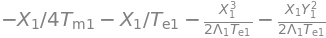

In [15]:
X1dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(X1_expr).diff(a1) * a1dot_dis
        + delaunay_to_orbelts(X1_expr).diff(e1) * e1dot_dis
    )
    .subs({
        sin(g1): X1 / sqrt(2 * G1),
        G1: Rational(1,2)*(X1**2+Y1**2)
        })
).expand()
X1dot_dis

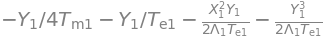

In [16]:
Y1dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(Y1_expr).diff(a1) * a1dot_dis
        + delaunay_to_orbelts(Y1_expr).diff(e1) * e1dot_dis
    )
    .subs({
        cos(g1): Y1 / sqrt(2 * G1),
        G1: Rational(1,2)*(X1**2+Y1**2)
        })
).expand()
Y1dot_dis

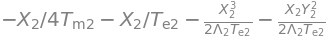

In [17]:
X2dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(X2_expr).diff(a2) * a2dot_dis
        + delaunay_to_orbelts(X2_expr).diff(e2) * e2dot_dis
    )
    .subs({
        sin(g2): X2 / sqrt(2 * G2),
        G2: Rational(1,2)*(X2**2+Y2**2)
        })
).simplify().expand()
X2dot_dis

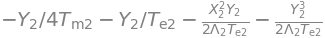

In [18]:
Y2dot_dis = (
    orbelts_to_delaunay(
        delaunay_to_orbelts(Y2_expr).diff(a2) * a2dot_dis
        + delaunay_to_orbelts(Y2_expr).diff(e2) * e2dot_dis
    )
    .subs({
        cos(g2): Y2 / sqrt(2 * G2),
        G2: Rational(1,2)*(X2**2+Y2**2)
        })
).simplify().expand()
Y2dot_dis

# Numerical Integration 

In [101]:
qval = 0.5

l1_dot = H3.diff(L1)
l2_dot = H3.diff(L2)
L1_dot = -H3.diff(l1) + L1dot_dis
L2_dot = -H3.diff(l2) + L2dot_dis
X1_dot = H3.diff(Y1) + X1dot_dis
X2_dot = H3.diff(Y2) + X2dot_dis
Y1_dot = -H3.diff(X1) + Y1dot_dis
Y2_dot = -H3.diff(X2) + Y2dot_dis


def plugin(expr):
    return expr.subs(
        {
            mu2: 6e-6,
            q: qval,
            f1: f1val,
            f2: f2val,
            f3: f3val,
            f4: f4val,
            j: 2,
            Tm1: np.inf,
            Tm2: 1e7,
            Te1: 2e3,
            Te2: 1e3,
            om1: -1e-4,
            om2: -2e-4,
        }
    )


l1_eom = lambdify([l1, l2, L1, L2, X1, X2, Y1, Y2], plugin(l1_dot))
l2_eom = lambdify([l1, l2, L1, L2, X1, X2, Y1, Y2], plugin(l2_dot))
L1_eom = lambdify([l1, l2, L1, L2, X1, X2, Y1, Y2], plugin(L1_dot))
L2_eom = lambdify([l1, l2, L1, L2, X1, X2, Y1, Y2], plugin(L2_dot))
X1_eom = lambdify([l1, l2, L1, L2, X1, X2, Y1, Y2], plugin(X1_dot))
X2_eom = lambdify([l1, l2, L1, L2, X1, X2, Y1, Y2], plugin(X2_dot))
Y1_eom = lambdify([l1, l2, L1, L2, X1, X2, Y1, Y2], plugin(Y1_dot))
Y2_eom = lambdify([l1, l2, L1, L2, X1, X2, Y1, Y2], plugin(Y2_dot))


def f(t, Y):
    Y = np.float64(Y)
    return np.float64(
        [
            l1_eom(*Y),  # 0
            l2_eom(*Y),  # 1
            L1_eom(*Y),  # 2
            L2_eom(*Y),  # 3
            X1_eom(*Y),  # 4
            X2_eom(*Y),  # 5
            Y1_eom(*Y),  # 6
            Y2_eom(*Y),  # 7
        ]
    )

In [102]:
T = 1e6
sol = sp.integrate.solve_ivp(
    f,
    (0, T),
    [0, 0, qval * np.sqrt(0.73), np.sqrt(1), 0, 0, 0, 0],
    t_eval=np.linspace(0, T, 10000),
    rtol=1e-9,
    atol=1e-9,
)
a1sol = sol.y[2, :] ** 2 / qval**2
a2sol = sol.y[3, :] ** 2
pom1sol = -np.arctan2(sol.y[4, :], sol.y[6, :])
pom2sol = -np.arctan2(sol.y[5, :], sol.y[7, :])
e1sol = np.sqrt((sol.y[4, :] ** 2 + sol.y[6, :] ** 2) / sol.y[2, :])
e2sol = np.sqrt((sol.y[5, :] ** 2 + sol.y[7, :] ** 2) / sol.y[3, :])
th1sol = (3 * sol.y[1, :] - 2 * sol.y[0, :] - pom1sol) % (2 * np.pi)
th2sol = (3 * sol.y[1, :] - 2 * sol.y[0, :] - pom2sol) % (2 * np.pi)

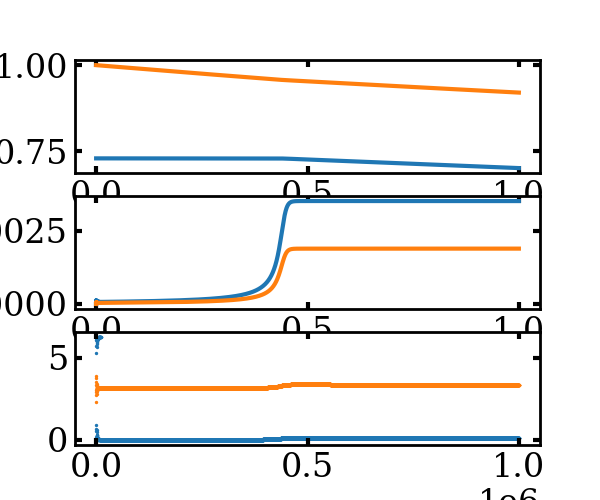

In [103]:
fig, ax = plt.subplots(3)
ax[0].plot(sol.t, a1sol)
ax[0].plot(sol.t, a2sol)
ax[1].plot(sol.t, e1sol)
ax[1].plot(sol.t, e2sol)
ax[2].scatter(sol.t, th1sol,s=2)
ax[2].scatter(sol.t, th2sol,s=2)

In [40]:
sp.integrate.solve_ivp?

Signature:
sp.integrate.solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a 1-D independent variable (time), y(t) is an
N-D vector-valued function (state), and an N-D
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note
that for stiff ODE solvers, the right-hand side must be
complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
To solve a problem in the complex domain, pass y0 with a complex data type.
Another option always available is to rew